In [1]:
!nvidia-smi

Fri Dec 22 23:50:41 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [3]:
%cd {HOME}
!git clone https://github.com/ashrithjacob/GroundingDINO.git
%cd {HOME}/GroundingDINO
!pip install -q -e .
!pip install -q roboflow

/content
fatal: destination path 'GroundingDINO' already exists and is not an empty directory.
/content/GroundingDINO
  Preparing metadata (setup.py) ... done
ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3108, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2901, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 169, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 242, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pi

In [4]:
!pip install deepface
!pip install matplotlib
!pip install cv2
!pip install face-recognition

ERROR: Could not find a version that satisfies the requirement cv2 (from versions: none)
ERROR: No matching distribution found for cv2


import os
import groundingdino
import os
import supervision as sv
import torch
from torchvision.ops import box_convert
import cv2
import numpy as np
import matplotlib.pyplot as plt
import face_recognition
from deepface import DeepFace
from groundingdino.util.inference import (
    load_model,
    load_image,
    predict,
    annotate,
)

## **CODE STARTS HERE:**

In [5]:
%cd {HOME}
!mkdir {HOME}/weights
%cd {HOME}/weights

!wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth
%cd {HOME}

/content
mkdir: cannot create directory ‘/content/weights’: File exists
/content/weights
/content


In [6]:
import os
import groundingdino
import os
import supervision as sv
import torch
from torchvision.ops import box_convert
import cv2
import numpy as np
import matplotlib.pyplot as plt
import face_recognition
from deepface import DeepFace
from deepface.commons import functions, realtime, distance as dst
from groundingdino.util.inference import (
    load_model,
    load_image,
    predict,
    annotate,
)

In [7]:
class FaceRecognition:
    def __init__(self):
        self.HOME = os.getcwd()
        self.backends = [
            "opencv",
            "ssd",
            "dlib",
            "mtcnn",
            "retinaface",
            "mediapipe",
            "yolov8",
            "yunet",
            "fastmtcnn",
        ]
        self.models = [
            "VGG-Face",
            "Facenet",
            "Facenet512",
            "OpenFace",
            "DeepFace",
            "DeepID",
            "ArcFace",
            "Dlib",
            "SFace",
        ]
        self.CONFIG_PATH = os.path.join(
            self.HOME, "GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py"
        )

        if (self.CONFIG_PATH, "; exist:", os.path.isfile(self.CONFIG_PATH)):
            self.WEIGHTS_NAME = "groundingdino_swint_ogc.pth"
            self.WEIGHTS_PATH = os.path.join(self.HOME, "weights", self.WEIGHTS_NAME)
            self.MODEL = load_model(self.CONFIG_PATH, self.WEIGHTS_PATH)

    def _box_face(
        self,
        image_path,
        text_prompt="human face",
        box_threshold=0.3,
        text_threshold=0.25,
    ):
        image_source, image = load_image(image_path)
        boxes, logits, phrases = predict(
            model=self.MODEL,
            image=image,
            caption=text_prompt,
            box_threshold=box_threshold,
            text_threshold=text_threshold,
        )
        return {
            "image": image_source,
            "boxes": boxes,
            "logits": logits,
            "phrases": phrases,
        }

    @classmethod
    def inflate_box(cls, boxes):
        boxes[:, 2:] *= 1.7  # scaling factor(fix box overlap issues)
        return boxes

    def display(self, image_path):
        properties = self._box_face(image_path=image_path)
        annotated_frame = annotate(
            image_source=properties["image"],
            boxes=properties["boxes"],
            logits=properties["logits"],
            phrases=properties["phrases"],
        )
        sv.plot_image(annotated_frame, (16, 16))

    def get_xyxy_mask(self, image_path):
        properties = self._box_face(image_path=image_path)
        img = properties["image"]
        boxes = properties["boxes"]
        boxes = FaceRecognition.inflate_box(boxes)
        h, w, _ = img.shape
        boxes = boxes * torch.Tensor([w, h, w, h])
        xyxy = box_convert(boxes=boxes, in_fmt="cxcywh", out_fmt="xyxy").numpy()
        xyxy = [tuple(map(int, map(round, mask))) for mask in xyxy]
        return img, xyxy

    def crop(self, image_path):
        img_list = []
        img, masks = self.get_xyxy_mask(image_path)
        for mask in masks:
            x1, y1, x2, y2 = map(int, map(round, mask))
            img_list.append(img[y1:y2, x1:x2])
        return img_list

    def deepface_box_face(self, image_path):
        boxes = []
        phrase = []
        confidence = []
        embedding_obj = DeepFace.represent(
            img_path=image_path,
            model_name=self.models[2],
            detector_backend=self.backends[4],
            enforce_detection=True,
        )
        image_source, _= load_image(image_path)
        h, w, _ = image_source.shape
        for e in embedding_obj:
            box = list(e["facial_area"].values())
            box = [x / w if i % 2 == 0 else x / h for i, x in enumerate(box)]
            box[0] += box[2]/2
            box[1] += box[3]/2
            boxes.append(box)
            confidence.append(e["face_confidence"])
            phrase.append("face_confidence")
        return {
            "image": image_source,
            "boxes": torch.Tensor(boxes),
            "logits": torch.Tensor(confidence),
            "phrases": phrase,
        }

    def display_deepface(self, image_path):
        properties = self.deepface_box_face(image_path=image_path)
        annotated_frame = annotate(
            image_source=properties["image"],
            boxes=properties["boxes"],
            logits=properties["logits"],
            phrases=properties["phrases"],
        )
        sv.plot_image(annotated_frame, (16, 16))

    def create_face_embedding(self, image_path):
        embeddings = []
        embedding_obj = DeepFace.represent(
            img_path=image_path,
            model_name=self.models[2],
            detector_backend=self.backends[4],
            enforce_detection=False,
        )
        embeddings = [e["embedding"] for e in embedding_obj]
        return embeddings


# initialize object
model = FaceRecognition()

final text_encoder_type: bert-base-uncased


# Add image list below:

In [8]:
img_list = ["img-2.jpg", "img-73.jpg", "img-90.jpg", "c-0-img-95.jpg", "img-71.jpg", "img-69.jpg"]

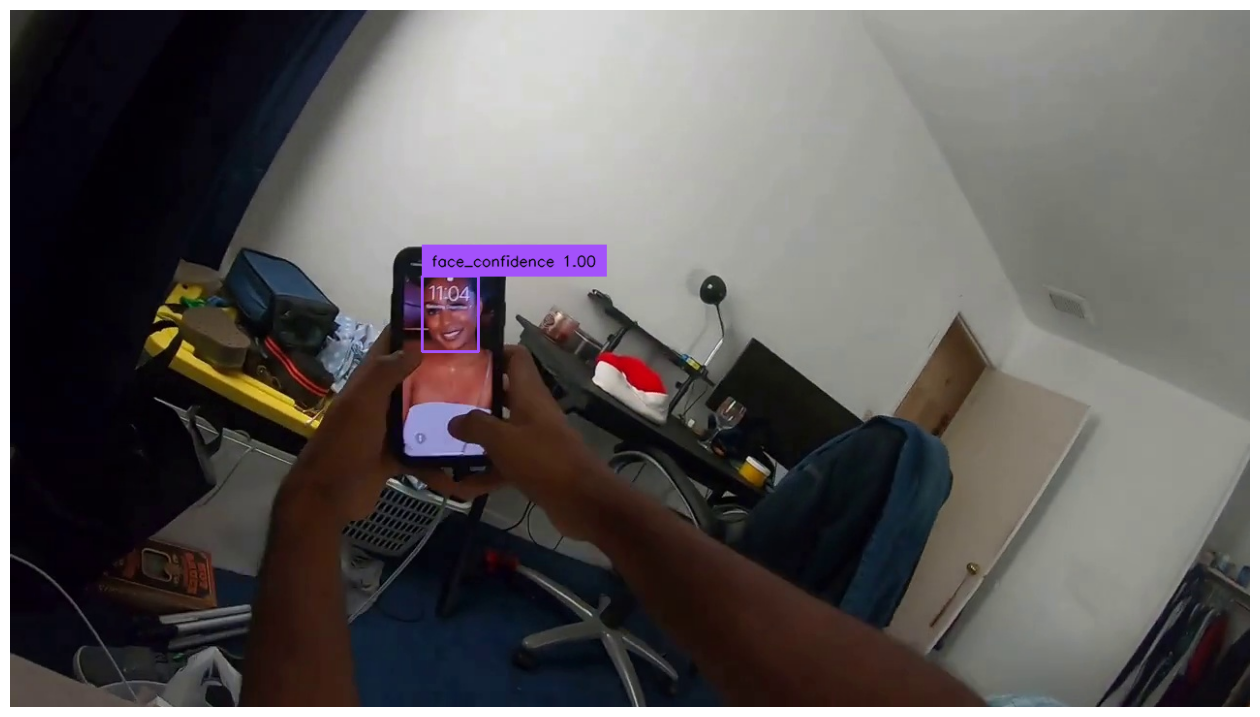

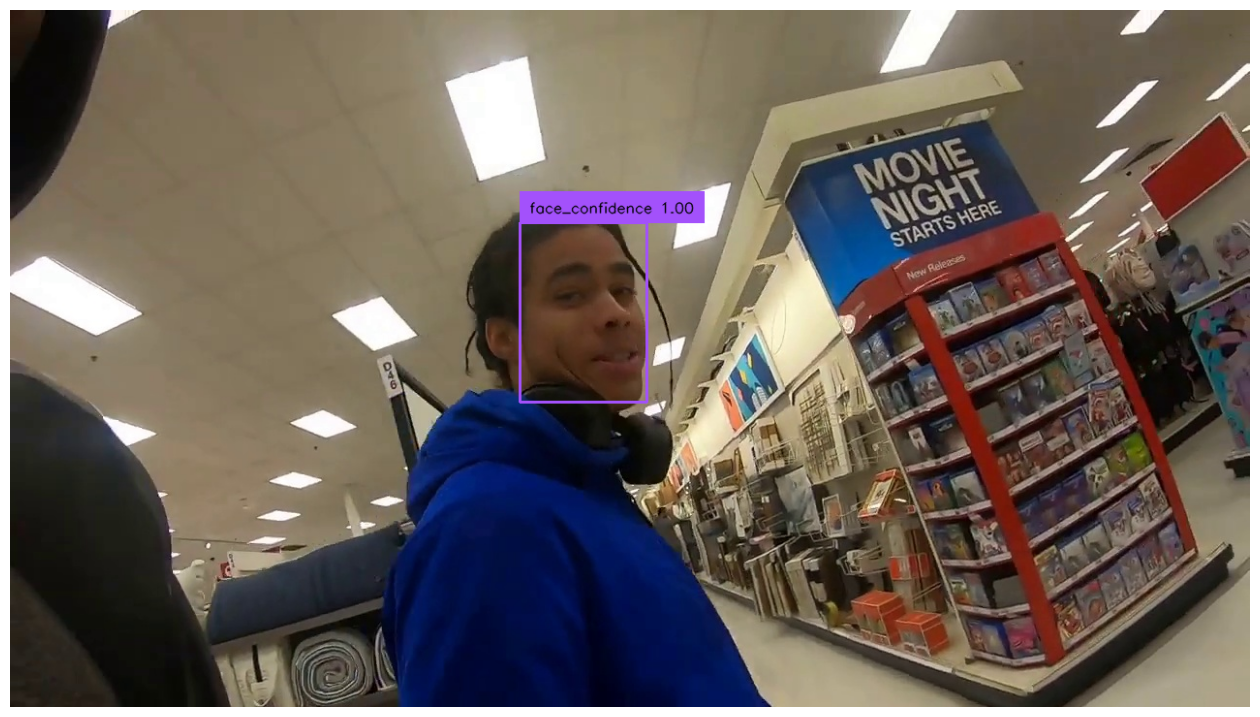

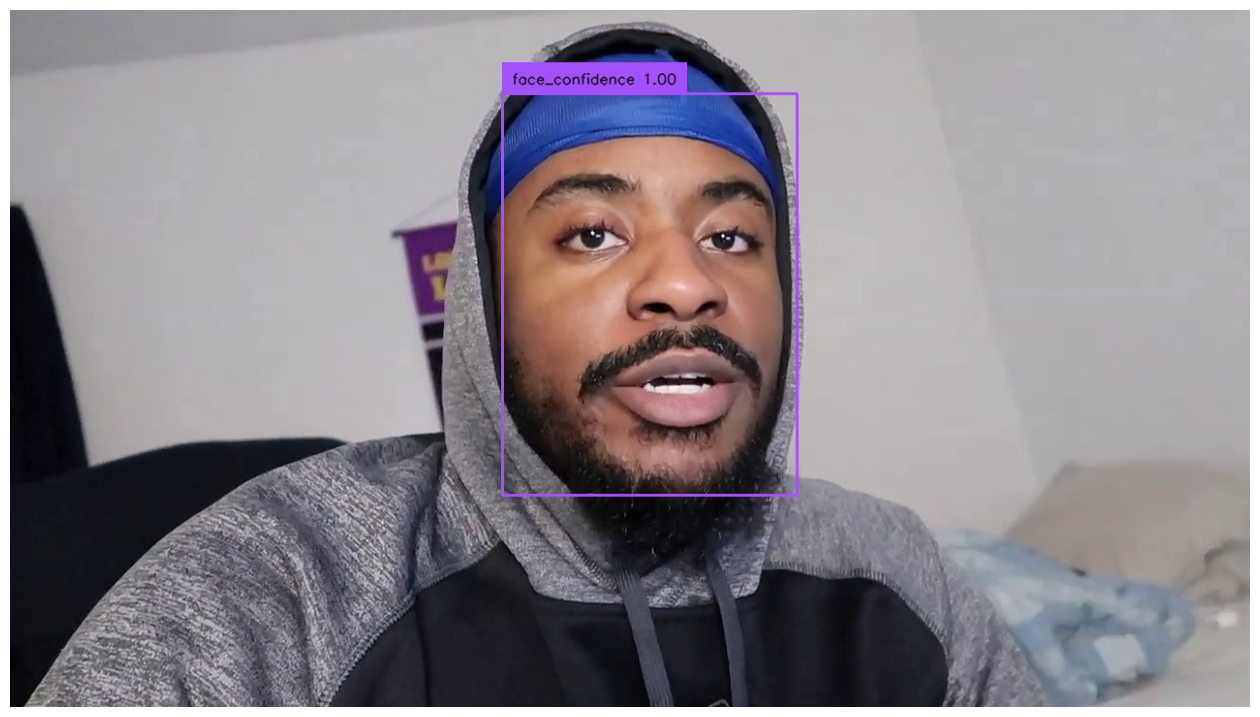

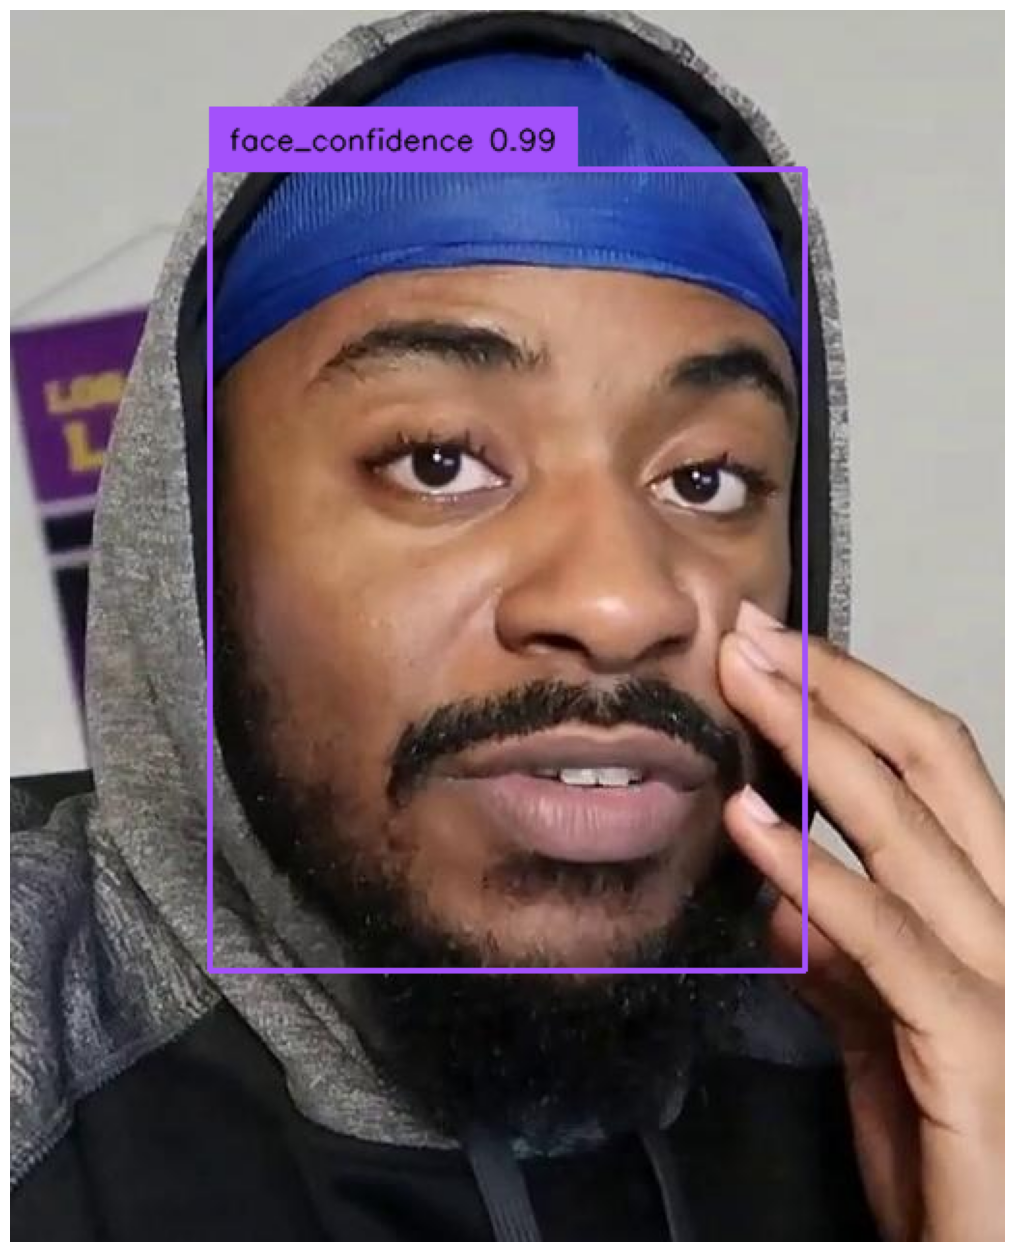

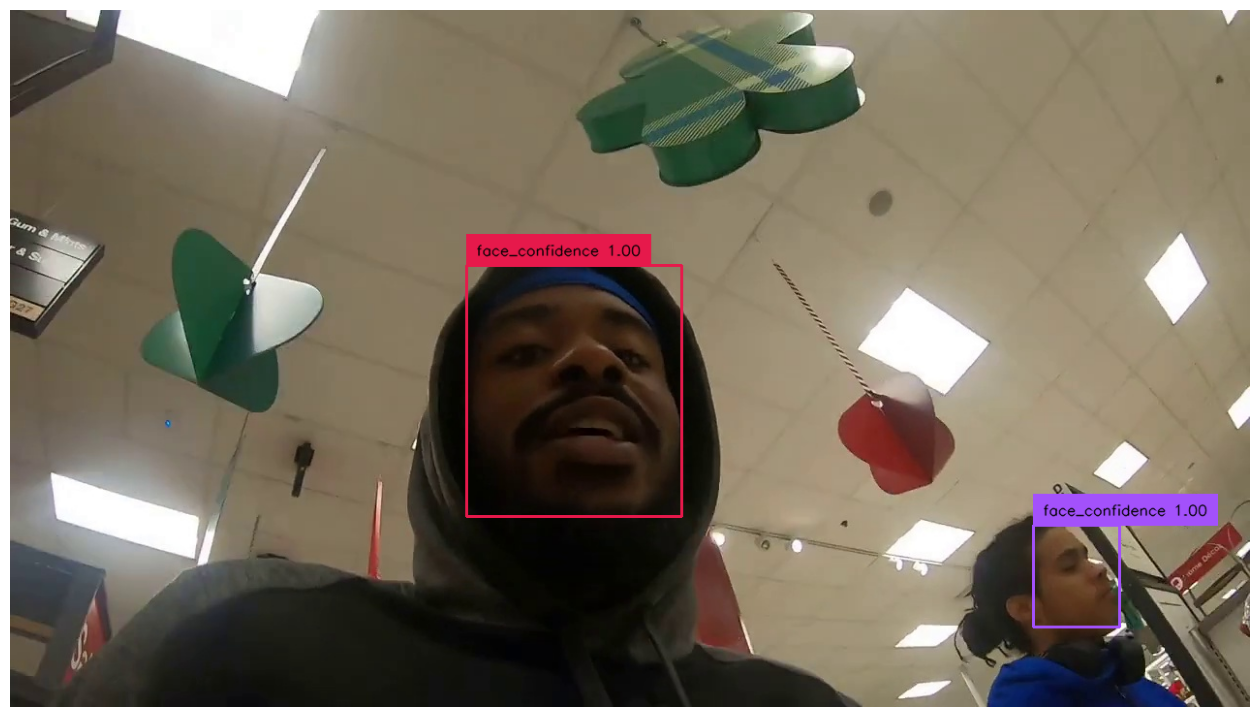

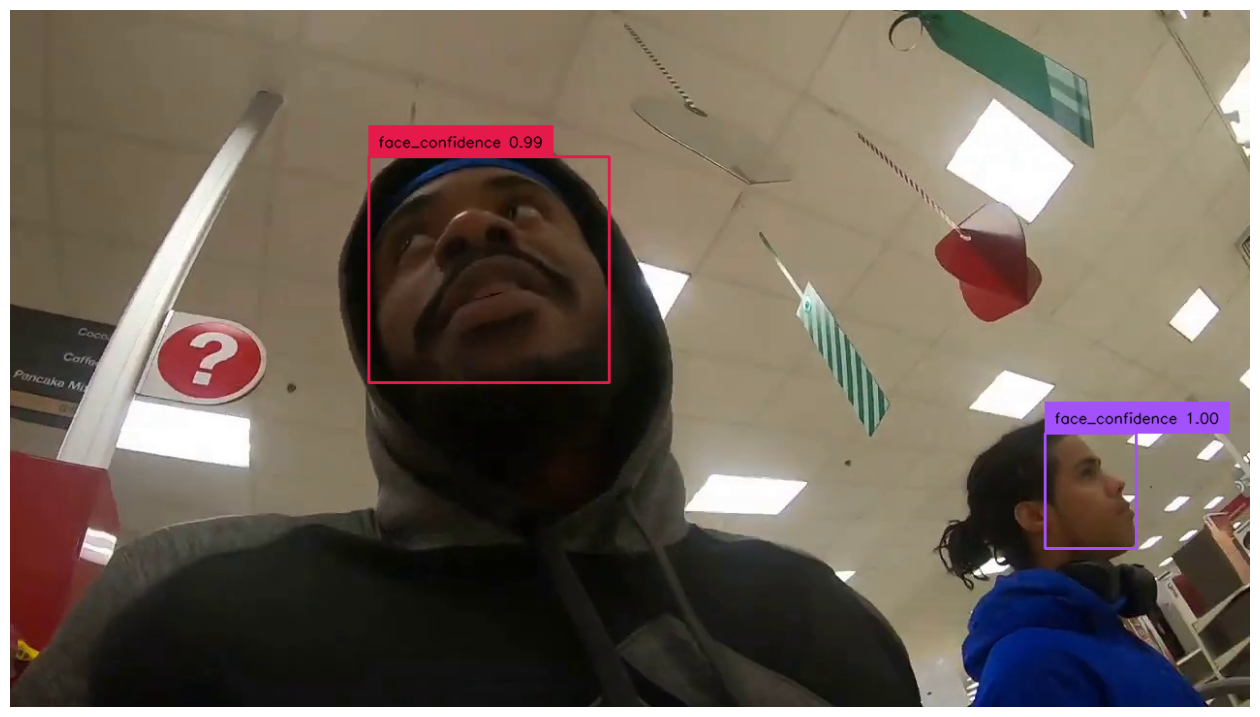

In [9]:
#DEEPFACE
emb ={}
for img in img_list:
  model.display_deepface(img)
  embeddings=model.create_face_embedding(img)
  emb[img]=embeddings

In [10]:
# play with index [0], [1] to reference different faces in the same image
distance = dst.findEuclideanDistance(emb["img-69.jpg"][0],emb["img-71.jpg"][1])
print(distance)

13.271577656616214


In [48]:
emb2 = {}

### GROUNDING DINO:



### Set which image from the img_list above you want to select

In [56]:
img_path = img_list[4]
emb2[img_path] =[]

Number if images cropped:2


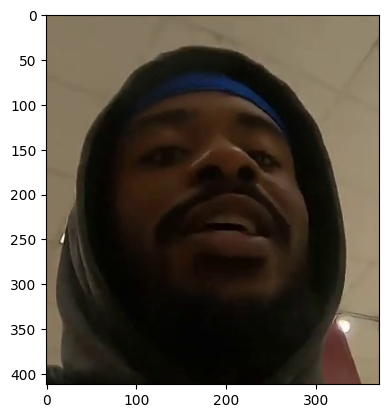

img cropped and saved as:'c-0-img-71.jpg'
img cropped and saved as:'c-1-img-71.jpg'


In [57]:
# Cropping faces using Grounding Dino[files with 'c-...]
crops = []
embeddings= []
img_list2 = model.crop(img_path)
print(f"Number if images cropped:{len(img_list2)}")
plt.imshow(img_list2[0])
plt.show()
for i in range(len(img_list2)):
  fname = f"c-{i}-{img_path}"
  crops.append(fname)
  plt.imsave(fname,img_list2[i])
  print(f"img cropped and saved as:'{fname}'")

In [58]:
# storing embeddings
for c in crops:
  embedding_objs = DeepFace.represent(img_path = c, model_name = model.models[2], enforce_detection=False)
  print(f"Number of Embeddings created for '{c}' (should be 1): {len(embedding_objs)}")
  embedding = embedding_objs[0]['embedding']
  print(f"Embedding length:{len(embedding)}")
  print(f"Embedding:{embedding}")
  print(f"Facial area:{embedding_objs[0]['facial_area']}")
  print(f"Face confidence:{embedding_objs[0]['face_confidence']}")
  emb2[img_path].append(embedding)

Number of Embeddings created for 'c-0-img-71.jpg' (should be 1): 1
Embedding length:512
Embedding:[1.343501329421997, -0.3164002299308777, -1.3794941902160645, -0.4051411747932434, -0.46267107129096985, -0.8904241919517517, -0.04360292851924896, 0.7556424736976624, 0.2581982910633087, -1.4934170246124268, -0.0787789449095726, -0.7733278274536133, 0.9275603890419006, -0.41107305884361267, 0.28855594992637634, -0.3499070107936859, -0.5739151835441589, -0.43102192878723145, -0.02794649451971054, -0.8633354902267456, -0.8996908068656921, -0.12814569473266602, -0.13653576374053955, 1.061599850654602, 0.6269365549087524, 1.5316966772079468, -0.8222194910049438, -1.9182264804840088, 1.1457748413085938, -0.2941569685935974, -1.1415601968765259, 0.6331419944763184, -0.31571170687675476, -0.1829022914171219, -1.160772681236267, 1.987506628036499, -0.5167685151100159, 0.6318323612213135, -0.28995653986930847, 0.2627623975276947, -1.0344343185424805, -0.6667141318321228, -0.2806788682937622, -0.61

In [59]:
# play with index [0], [1] to reference different faces in the same image
# add only images fro which you have run grounding dino section
distance = dst.findEuclideanDistance(emb2["img-2.jpg"][0],emb2["img-71.jpg"][1])
print(distance)

20.536087378949684
